In [1]:
from model_utils import *

In [2]:
FILE = "./data/slice_elmundo.json"
DATASET_NAME = 'elmundo'
LOG_DIR = "./news-classification"
MAX_CATE_SIZE = 3000
MODEL_NAME = 'skimai/spanberta-base-cased'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128
LEARN_RATE = 3e-5
EPOCH = 6

In [3]:
# classifier label set
'''
target_label = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
'''

target_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
# source item label set
source_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
source_label_dic = {}
for idx, label in enumerate(source_label):
    source_label_dic[label] = idx

## Load Data

In [4]:
def load_test_data(path,cate_size,type='JSON',percentage=1):
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    labels = df['category'].tolist()
    contents = df['content'].tolist()
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]

    # itos                                        
    label_set = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
    # stoi
    for idx, label in enumerate(label_set):
        label_dic[label] = idx
    """
    label_count = {}
    flitered_labels = []
    flitered_contents = []
    for cate, cont in zip(labels, contents):
        if cate not in label_count.keys():
            label_count[cate] = 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        elif label_count[cate] < cate_size:
            label_count[cate] += 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
    
    """
    # shuffle
    idx_list = list(range(0, len(labels), 1))
    random.shuffle(idx_list)
    shuffled_labels = []
    shuffled_contents = []
    for idp in idx_list:
        shuffled_labels.append(labels[idp])
        shuffled_contents.append(contents[idp])
    print('Data loaded label:{} content:{} '.format(len(labels), len(contents)))
    return shuffled_labels, shuffled_contents, label_set, label_dic

In [5]:
class TestDataset(Dataset):
    def __init__(self,labels,inputs,origins,ldic):
        self.labels = labels
        self.origins = origins
        self.inputs = inputs
        self.ldic = ldic
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):
        y = self.labels[idx]
        y_encoded = torch.Tensor([self.ldic.get(y,-1)]).long().squeeze(0)
        res ={
            'input_ids':self.inputs[idx]['input_ids'][0],
            'attention_mask': self.inputs[idx]['attention_mask'][0],
            'origin_contents':self.origins[idx],
            'targets':y_encoded,
        }
        return res

In [6]:
# load test data and label info
labels,contents,lset,ldic = load_test_data(FILE,MAX_CATE_SIZE)

# encode
start = time.time()
encoding_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print("encoding time costs: {}".format(time.time()-start))

# load valid dataset 
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic)
train_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic )
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                    'val')
test_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                   'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))
      
# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded label:16211 content:16211 


100%|██████████| 16211/16211 [00:03<00:00, 4320.98it/s]

Tokenizer loaded...
encoding time costs: 8.930969476699829
data loaded 
train:11347
valid:2433
test:2431


In [7]:
if not os.path.exists('./{}-results'.format(DATASET_NAME)):
    os.makedirs('./{}-results'.format(DATASET_NAME))
if not os.path.exists('./{}-results/{}-{}'.format(DATASET_NAME,LEARN_RATE, MAX_SEQ_LENGTH)):
    os.makedirs('./{}-results/{}-{}'.format(DATASET_NAME,LEARN_RATE, MAX_SEQ_LENGTH))

In [8]:
#load model
model = RobertaForSequenceClassification(MODEL_NAME,len(source_label))
model.apply(weight_init)

RobertaForSequenceClassification(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()
acclist,losslist = train_classifier(model,EPOCH,LEARN_RATE, MAX_SEQ_LENGTH,
                                    train_val_loaders,criterion,'10-26',
                                    optimizer,scheduler, path='elmundo-results')

epoch 0


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 0 batch 88, loss: 1.519 acc: 39.759  
validating...
After Epoch 0 , valid acc: 0.3497739416358405, avg loss1.7014772302648995  avg acc0.3077503130499526
epoch 1


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1 batch 88, loss: 0.8784 acc: 73.494  
validating...
After Epoch 1 , valid acc: 0.5713111385121249, avg loss1.511352612731162  avg acc0.38974560460944907
epoch 2


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2 batch 88, loss: 0.7604 acc: 72.2892 
validating...
After Epoch 2 , valid acc: 0.7048910809699959, avg loss1.2827688681052418  avg acc0.500424098077704
epoch 3


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3 batch 88, loss: 0.4926 acc: 85.5422 
validating...
After Epoch 3 , valid acc: 0.7122893547061241, avg loss1.0825628238949883  avg acc0.5854105502064437
epoch 4


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4 batch 88, loss: 0.2356 acc: 89.1566 
validating...
After Epoch 4 , valid acc: 0.7163995067817509, avg loss0.9145056823331319  avg acc0.6529864542439421
epoch 5


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5 batch 88, loss: 0.2254 acc: 92.7711  
validating...
After Epoch 5 , valid acc: 0.7024249897246199, avg loss0.7817737516573864  avg acc0.7046151600785163


## Acc and loss

In [10]:
import matplotlib.pyplot as plt
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

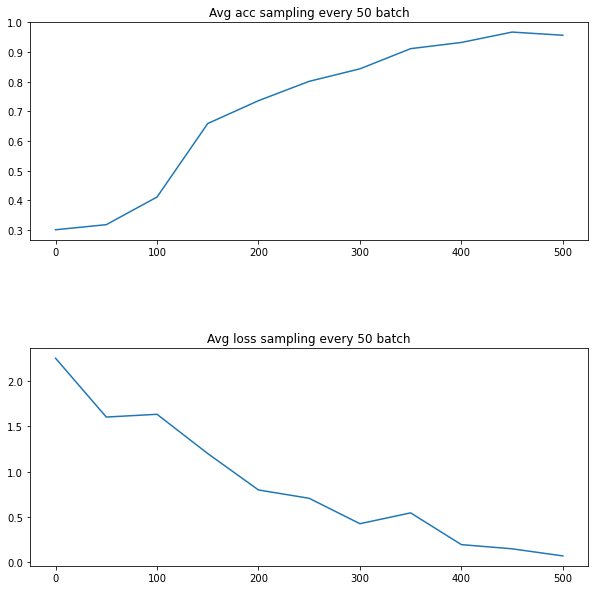

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()
plt.savefig('./img/{}-{}-acc-loss.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))

In [12]:
#visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
iterator = train_val_loaders
true_labels = []
pred_labels = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['valid'])):
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].cuda()
        targets = data['targets']
        origins = data['origin_contents']
        targets.numpy()
        # print(len(origins), len(targets))
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        # print screen 
        # print(len(data))
        for i in range(len(origins)):
            print("idx:{}".format(i))
            print(origins[i])
            print('pred: ',target_label[outputs[i]])
            print('true: ',source_label[targets[i]])
            print('--------------')
        pred_labels += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_labels))
    print(pred_labels[:15])
        

  0%|          | 0/20 [00:00<?, ?it/s]

idx:0
Aitana Ocaña lanzó el pasado 23 de julio Aunque No Sea Conmigo, un nuevo sencillo en el que colabora con Evaluna Montaner.
pred:  cultura
true:  cultura
--------------
idx:1
Seis lugares para no perderse la berrea.Vuelven los bramidos y los choques de cuernas que interrumpen la tranquilidad de los bosques y las praderas españolas.
pred:  economia
true:  economia
--------------
idx:2
El mayor sentimiento que detectan estos expertos en salud mental es el de "vergüenza", que se da en afectados que han perdido todo.
pred:  cultura
true:  economia
--------------
idx:3
 Acaba de recibir el premio al mejor parque de naturaleza del año. .Dicen que el cierzo, el viento dominante que sopla en todo el eje del Ebro, te puede dejar algo alocado.
pred:  cultura
true:  cultura
--------------
idx:4
Hace años que los grandes caseros desembarcaron en las grandes urbes y muchos ven en ese desembarco el germen del aumento de los precios.
pred:  economia
true:  economia
--------------
idx:5
Nokia pon

idx:0
Un terremoto de magnitud 6,4 sacude Islas Salomón, en el Pacífico Sur.Las autoridades no informaron de daños ni emitieron una alerta de tsunami.
pred:  internacional
true:  internacional
--------------
idx:1
297 días después, protagonista de nuevo en una final ACB. «Vivo mi carrera como si fuera el último partido.
pred:  deportes
true:  deportes
--------------
idx:2
 Y lo fue por inventar, a su modo, la telerrealidad. Desde su programa de religión evangélica convirtió su casa, su vida y sus pestañas en un emblema y, de paso, en la perfecta imagen de un país entero.
pred:  cultura
true:  cultura
--------------
idx:3
 La intención de la organización es celebrar los conciertos. Antonio Moral, director del festival, y la consejera de Cultura Patricia del Pozo, cruzan los dedos a fin de que para esas fechas la crisis sanitaria haya desaparecido y Granada esté en fase cuatro.
pred:  cultura
true:  cultura
--------------
idx:4
El ahorro del miedo.La tasa de ahorro es un indicador que ti

idx:0
 
Sus siguientes incursiones en Wikipedia fueron ediciones en artículos que él consideraba que no estaban bien escritos.
pred:  cultura
true:  tecnologia
--------------
idx:1
 Casi mil personas pueden perder su puesto de trabajo, de forma directa o indirecta, en una zona en la que se registra la mayor tasa de desempleo de la comunidad autónoma.
pred:  economia
true:  economia
--------------
idx:2
 La frase de Baudelaire quiere ser a la vez advertencia y libro de estilo. Si el sonido de la banda de Nueva York reordenó la energía de un tiempo convulso y eléctrico del que surgió entera, como Atenea de la cabeza de Zeus, la promesa de un futuro no necesariamente mejor pero sí infinitamente más deseable (y aun deseado), la película que fue presentada en Cannes y que ahora se estrena en Apple TV ofrece la perfecta imagen sinestésica de ese estallido.
pred:  economia
true:  economia
--------------
idx:3
 De su juicio depende que el asunto continúe en vía judicial.La juez que investiga l

idx:0
 "Ante el maná de dinero, todo el mundo anda metido en el tráfico", dice impotente un policía.Marsella, jueves 2 de septiembre.
pred:  internacional
true:  economia
--------------
idx:1
La romántica aventura de Maté: 1.000 kilómetros tras la Vuelta para reivindicar la esencia del ciclismo.
pred:  deportes
true:  deportes
--------------
idx:2
 Escritor, comediante y periodista. Alcanzó la fama con Titania McGrath, una parodia de la activista de izquierdas cuyo último libro, Mi pequeño libro de activismo interseccional, publica Alianza.
pred:  cultura
true:  cultura
--------------
idx:3
 Primoz Roglic por un lado y el Ineos de cuatro cabezas por el otro se presentan como los principales aspirantes a desbancar al joven talento esloveno.
pred:  deportes
true:  deportes
--------------
idx:4
Los chollos del día en Amazon: una tablet Samsung Galaxy al 22%, una sudadera Helly Hansen al 32%, una mochila de Stranger Things.
pred:  cultura
true:  cultura
--------------
idx:5
Dos bodegas esp

idx:0
 Desde el aeropuerto de Fiumicino hasta la recepción en el Palacio del Quirinal, el capitán de Italia portó el trofeo de la Eurocopa y dedicó el título a Davide Astori, el ex internacional fallecido en 2018 a causa de una anomalía cardiaca.
pred:  deportes
true:  deportes
--------------
idx:1
30 Eurosport 1) frente a Daniil Medvedev, en el Abierto de Estados Unidos, quedarse solo como el tenista con más títulos en los cuatro majors, superando la igualdad a 20 coronas con Roger Federer y Rafael Nadal, y convertirse, tras Donald Budge y Rod Laver, en el tercer jugador de la historia que consigue los cuatro grandes en un mismo año.
pred:  deportes
true:  deportes
--------------
idx:2
El CIS ha culminado este jueves su polémico papel en las elecciones autonómicas de Madrid publicando como una "encuesta metodológica" el sondeo que realizó durante los últimos días de la campaña saltándose la Ley Electoral.
pred:  cultura
true:  cultura
--------------
idx:3
El Castellón da los primeros 

idx:0
Muerte de una playa: el volcán acaba con Los Guirres, "la mejor ola" para los surfistas de La Palma.
pred:  economia
true:  economia
--------------
idx:1
La presidenta de la Comunidad de Madrid estalla contra el PSOE después de que los Presupuestos Generales del Estado elaborados por el Ejecutivo de Pedro Sánchez incluyan una reducción de 100 millones de euros en la partida que recibirá la región en 2022.
pred:  economia
true:  economia
--------------
idx:2
Comprar a deuda voto de jóvenes en paro.El mejor apoyo tanto a la industria cultural como a la emancipación de los jóvenes es un puesto de trabajo que valore su productividad.
pred:  economia
true:  economia
--------------
idx:3
 En una muestra de clase y determinación, el español derrotó a Nikoloz Basilashvili, 28º favorito, por 6-4, 6-2 y 6-4, en una hora y 55 minutos, y buscará los octavos ante Jan-Lennard Struff.
pred:  deportes
true:  deportes
--------------
idx:4
Por tierra y por aire, la nueva misión de Amazon parece se

idx:0
Logitch ha anunciado una estación de... estacionamiento. Es mejor el nombre en inglés: dock station.
pred:  cultura
true:  tecnologia
--------------
idx:1
 «He oído decir a muchos que se indignan y se lamentan de ella, como si una conquista se hiciera co.
pred:  cultura
true:  economia
--------------
idx:2
La ciudad italiana celebra su centenario mientras debate cómo evitar que su principal industria, las visitas de extranjeros, no destroce por completo su inigualable patrimonio artístico.
pred:  cultura
true:  economia
--------------
idx:3
ERC amenaza con boicotear el mando de Laura Borràs en el Parlament si JxCat no inviste a Pere Aragonès.
pred:  economia
true:  economia
--------------
idx:4
 La normativa en algunas ciudades de Estados Unidos, por ejemplo San Francisco y en Nueva York, exige la vacunación para poder acceder a eventos deportivos disputados en interiores.
pred:  internacional
true:  deportes
--------------
idx:5
Decepcionante salida del Tribunal Supremo.Resulta 

idx:0
Un disparo accidental deja a una niña de 9 años grave en Llucmajor.La niña fue estabilizada en el lugar de los hechos desde donde fue llevada al Hospital Universitario Son Espases de Palma.
pred:  economia
true:  economia
--------------
idx:1
 En el de Moto2, en su caso. Sin embargo, durante los entrenamientos libres del GP Emilia Romagna, se convirtió en protagonista por su destreza, cuando parecía estar destinado a probar la dureza de un asfalto húmedo y resbaladizo.
pred:  deportes
true:  deportes
--------------
idx:2
La plataforma también buscará formas de disuadirles para que vean contenido que mejore su bienestar.
pred:  television
true:  tecnologia
--------------
idx:3
 El MIT le considera uno de los pensadores tecnológicos más brillantes y a él le debemos conceptos ya familiares como marketing viral o nativos digitales.
pred:  cultura
true:  economia
--------------
idx:4
El gobierno francés clama sanciones tras los vergonzosos incidentes en Niza: "Se ha pasado la línea ro

idx:0
 Desde 'El orfanato' ha sido víctima, superviviente y también psicópata.Se ha enfrentado a los fantasmas en El orfanato y a lo sobrenatural en El pacto, ha sido una psicópata en No dormirás, ha perdido la vista en la angustiosa Los ojos de Julia, incluso ha interpretado a un cadáver exquisito en El cuerpo.
pred:  economia
true:  cultura
--------------
idx:1
Salga el sol por donde quiera.Hay personas, servidor entre ellas, que somos más de los piratas Rolling Stones que de los Lores Beatles; del Sabina porrero que de un Fran Sinatra de platino nasal; del desgarrador "último brindis de un bohemio por una reina", que del "Perdóname" de Ricky Martin.
pred:  cultura
true:  economia
--------------
idx:2
 Barrunto que dirán que Batet cumplió la ley al cumplir la ley.En los últimos días, Unidas Podemos, el socio comunista de los dos que forman el Gobierno del socialista Sánchez, se ha situado públicamente y sin ambages en el sitio que le corresponde: fuera de la legalidad y de la polític

idx:0
Insiders es el nuevo reality show de Neflixt, una original propuesta que da una vuelta de tuerca a los programas de convivencia.
pred:  television
true:  television
--------------
idx:1
El tipo de interés nominal (TIN) de los préstamos al consumo ha crecido un 23,7% desde el último trimestre de 2020, según el análisis realizado por la 'app' Fintonic.
pred:  economia
true:  economia
--------------
idx:2
.. hasta el momento. Raised by Wolves, Ted Lasso, Mare of Easttown o Them son algunas que puedes recuperar estas vacaciones.
pred:  economia
true:  economia
--------------
idx:3
La 'humanización' del espacio, prioridad en el nuevo Instituto Oncologico del Provincial de Castellón.
pred:  economia
true:  television
--------------
idx:4
 Casi 16 meses en los que, con estado de alarma y sin él, Urkullu asumió el liderazgo y, por tanto, el desgaste de la adopción de restricciones que afectaron especialmente a la hostelería con limitaciones de espacios, aforos y horarios.
pred:  economia

idx:0
PP, Ciudadanos y Vox reclaman ante la Junta Electoral y la Fiscalía para impedir que Alberto Rodríguez conserve el escaño.
pred:  cultura
true:  cultura
--------------
idx:1
No hay duda de que la carrera de Ricardo Reis (Oporto, 1978) ha sido meteórica. Se licenció en Económicas, obtuvo el doctorado de Filosofía en la Universidad Harvard y a los 29 años ya era uno de los profesores más jóvenes de la historia de Columbia.
pred:  economia
true:  economia
--------------
idx:2
Vinicius es el séptimo brasileño con más partidos de un Madrid en el que sólo Ronaldo ha triunfado con mayúsculas en la delantera.
pred:  deportes
true:  deportes
--------------
idx:3
 Alonso, sexto tras una apasionante carrera que también pudo ganar Norris.A la estela de Lewis Hamilton y Max Verstappen, empapado por una lluvia que puso todo del revés, Carlos Sainz subió en Sochi a su tercer podio del Mundial 2021.
pred:  deportes
true:  deportes
--------------
idx:4
Paula Sánchez, la diplomática que resiste en

idx:0
El 20 de diciembre se concretará el nuevo calendario futbolístico y el presidente de la FIFA espera que las "motivacionesdeportivas estén por encima de las financieras".
pred:  deportes
true:  deportes
--------------
idx:1
El salpicón no engorda. Los cinco mejores de Madrid.En la capital no hay mar pero apreciamos el marisco.
pred:  economia
true:  economia
--------------
idx:2
El prefecto de Roma, tras la Eurocopa de Italia: "Las celebraciones en el autobús de la selección estaban prohibidas".
pred:  deportes
true:  deportes
--------------
idx:3
Convoca una convención política en julio para impulsar el partido con ideas pero con la base de abanderar la "moderación" y la "concordia" contra los "extremos" y la "crispación".
pred:  economia
true:  cultura
--------------
idx:4
Golpe de efecto del Premio Planeta: corona a Carmen Mola y desvela su identidad.La novela ganadora del Premio Planeta, escrita a seis manos, se titula y está ambientada en Madrid en 1834.
pred:  cultura
true: 

idx:0
 El suizo encara su última oportunidad.Han pasado casi dos años desde que Novak Djokovic levantó dos bolas de partido ante Roger Federer para ganar su quinto título en Wimbledon y decimoséptimo Grand Slam.
pred:  deportes
true:  deportes
--------------
idx:1
En medio de esta oleada de periodismo partidista, o sectario, o desinformativo que nos invade desde que las fuerzas políticas que se popularizaron a base de fake news llegaron al palacio de la Moncloa, es una iniciativa interesante la de la Asociación de Medios de Información (AMI), por reconducir la situación, en particular con un seminario en internet (ya saben, webinar en inglés) recién celebrado bajo el título Periodismo constructivo, una alternativa rentable pare reforzar la confianza de l.
pred:  economia
true:  economia
--------------
idx:2
Cuándo encienden las luces de Navidad 2021 en Madrid.Madrid ha adelantado más que nunca el montaje de luces de Navidad; sin embargo, aún quedan unas semanas para disfrutar de su enc

idx:0
Pablo Casado rechaza, de entrada, la reforma de la Constitución que quiere aprobar Pedro Sánchez. El presidente del Gobierno ha nombrado al ministro Félix Bolaños secretario Constitucional y de Nuevos Derechos del PSOE, durante el 40 Congreso de los socialistas.
pred:  economia
true:  economia
--------------
idx:1
 Sin la primera no existe la segunda. Ni absolutamente nada. Basta ver a la lealísima oposición insistir, desde hace una semana, en el calamitoso estado en el que se encuentra la Atención Primaria en la Marisma -léase: los ambulatorios que perdimos, por seguir con la retórica de los costumbristas- para caer en la cuenta de que el Quirinale, primitivo hogar de mareantes, tiene dos grandes problemas, dos.
pred:  ciencia-y-salud
true:  economia
--------------
idx:2
Las mujeres en el ejército británico sufren acoso sexual de forma "generalizada".De un total de 750 veteranas entrevistadas, el 22,5% dice haber sufrido algún tipo de agresión o maltrato.
pred:  internacional
tr

idx:0
 A su manera, la puesta en escena de Maixabel, de Icíar Bollaín con la ayuda de Isa Campo en el guion, adopta para sí estos preceptos no tanto para su historia ni sus personajes como para aquello que les define por dentro.
pred:  television
true:  cultura
--------------
idx:1
303 contagios en las últimas 24 horas.Otro día de buenas noticias. La incidencia acumulada (IA) del coronavirus continúa descendiendo, aunque poco a poco.
pred:  economia
true:  economia
--------------
idx:2
 Y es que bajo este pseudónimo femenino que ha obtenido el Premio Planeta y cuya obra era recomendada por el Instituto de la Mujer dentro de sus "lecturas feministas" se escondían tres señoros muy avispados.
pred:  cultura
true:  cultura
--------------
idx:3
 En este caso, le bastó el esquema de una situación idéntica, desarrollada a través de una rica gama de variantes sobre la misma, según la lógica prevista y previsible de un grupo de figuras que no simulan su condición de personajes, porque todo el m

idx:0
 El 15 de octubre también llegan a las salas de cine ,  o .Además de El buen patrón, lo nuevo de Javier Bardem, el 15 de octubre llegan a la cartelera Venom: Habrá matanza, Un segundo o Pleasure.
pred:  cultura
true:  economia
--------------
idx:1
El Grupo Parlamentario Popular ha registrado una proposición no de ley en el Congreso de los Diputados en la que insta al Gobierno a poner en marcha un Plan Nacional Integral de Modernización y Renovación del parque español de vehículos para mejorar la seguridad vial, reducir las emisiones de CO2 y otros contaminantes, y contribuir, aprovechando los fondos europeos de recuperación económica, a la transformación de la industria auxiliar y la cadena de valor del sector de la automoción.
pred:  economia
true:  economia
--------------
idx:2
 Johana Yepes, personal trainer de Yoofit, explica cuáles son los mejores  para las mujeres y en qué momento del mes hacerlos para sacarles el máximo partido.
pred:  ciencia-y-salud
true:  deportes
-----

idx:0
Un año después, Emiliano Sala en el recuerdo y su traspaso en los tribunales.Un año después de que la avioneta en la que el futbolista argentino Emiliano Sala se hundiese en el Canal de La Mancha, el recuerdo del jugador argentino permanece vivo en los clubes FC Nantes y Cardiff City, que le rendirán sendos homenajes en el primer aniversario de su muerte mientras, por otro lado, dirimen en el Tribunal de Arbitraje Deportivo (TAS) sus diferencias por el dinero del traspaso del delantero.
pred:  deportes
true:  deportes
--------------
idx:1
La visita al mítico Coliseo de Roma es uno de los puntos clave en cualquier ruta turística por la capital romana.
pred:  economia
true:  economia
--------------
idx:2
 "Es apasionante, aunque no dejas de pensar en la gente que está sufriendo esto", afirma.En la historia de Eduardo Suárez se da una de esas paradojas espacio/temporales que convierten la ciencia, y por extensión la vida, en algo inabarcable.
pred:  cultura
true:  economia
---------

idx:0
Un nuevo vuelo de una cápsula Soyuz despegó este martes desde Baikonur, en Kazajistán. Pero la tripulación no era la habitual.
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
El limbo de los riders.A partir de mañana, los repartidores de las plataformas de comida a domicilio no podrán trabajar como autónomos.
pred:  economia
true:  economia
--------------
idx:2
Barty consigue su segundo grande al imponerse a Pliskova en una final dominada por las emociones.La 'número uno' se impone a la checa, cuya reacción tras un pésimo comienzo se verifica insuficiente (6-3, 6-7 [4], 6-3).
pred:  deportes
true:  deportes
--------------
idx:3
 A continuación, algunos consejos y recomendaciones de fotógrafos expertos y aficionados a tener en cuenta.
pred:  tecnologia
true:  cultura
--------------
idx:4
Los madrileños eligen los escenarios más cinematográficos de la ciudad.Ciudad de Madrid Film Office y EGEDA han anunciado a los 12 ganadores del certamen que busca espacios de p

idx:0
 El organismo internacional dirigido por Kristalina Georgieva, en una demoledora revisión de nuestra economía, pide que se retiren los nuevos impuestos verdes (al diésel y a los envases de plástico) y la subida de.
pred:  economia
true:  economia
--------------
idx:1
 Según el comparador bancario HelpMyCash.com, esta opción tiene más gastos asociados, pero puede salir más a cuenta que la subrogación si se consiguen unas buenas condiciones.
pred:  economia
true:  economia
--------------
idx:2
Tres bancos para abrir una cuenta sin nómina ni comisiones y con tarjetas gratis.El cobro de comisiones por parte de los bancos está a la orden del día.
pred:  economia
true:  economia
--------------
idx:3
 Y con el regreso de la cerveza, vuelven sus virtudes: antioxidante, vitamínica, con interesante aporte de calcio.
pred:  economia
true:  cultura
--------------
idx:4
Las vacaciones de verano son una época en la que grandes y pequeños pueden entretenerse con todo tipo de actividades.
pred: 

7 7


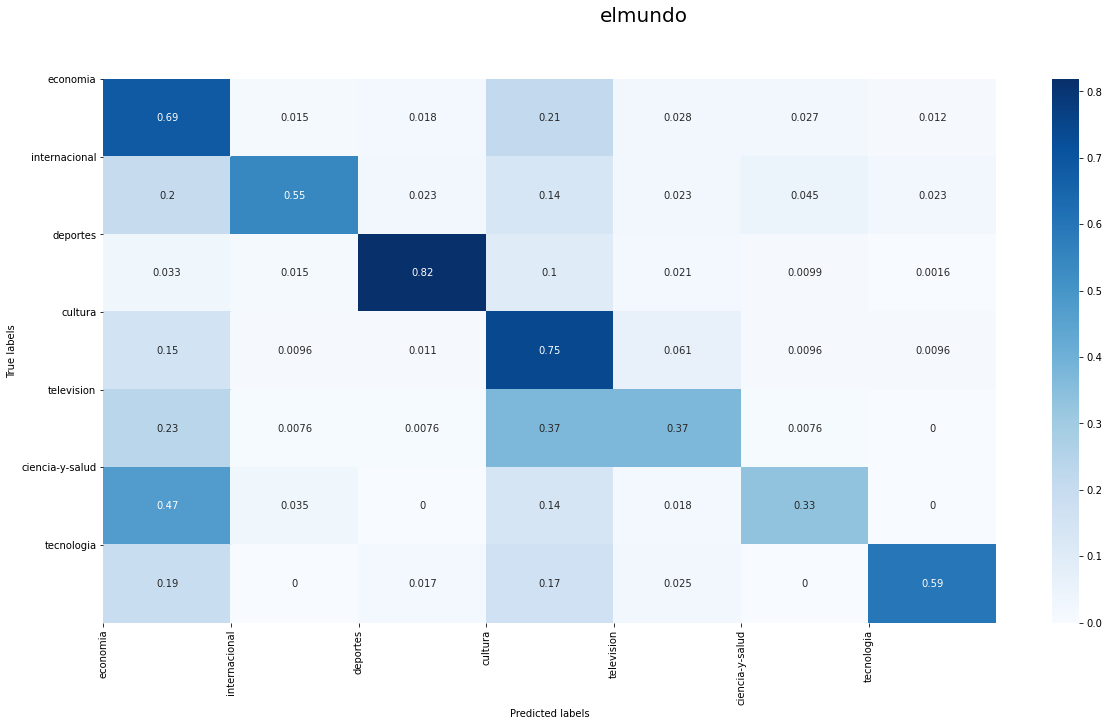

In [14]:
true_cate = [source_label[i] for i in true_labels]
pred_cate = [target_label[j] for j in pred_labels]

con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# =====diy confusion matrix=====
matrix = [[0 for i in range(len(target_label))] for j in range(len(source_label))]
print(len(matrix),len(matrix[0]))
sums = [0 for i in range(len(source_label))]
for x,y in  zip(true_labels,pred_labels):
    matrix[x][y] += 1
    sums[x] += 1
# normalization
for i in range(len(source_label)):
    for j in range(len(target_label)):
        matrix[i][j] /= sums[i]
    
# === plot ===
fig = plt.figure(figsize=(20, 10))
sns.heatmap(matrix, annot=True, cmap='Blues')
catex = list(range(0,len(target_label),1))
catey = list(range(0,len(source_label),1))
fig.suptitle('elmundo',fontsize=20)

plt.xlabel('Predicted labels')
plt.xticks(catex,target_label)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catey,source_label)
plt.yticks(rotation=360)
plt.show()
# plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))